<font size="8"> **Matching biological and environmental data** </font>  


# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [2]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant modules

In [3]:
from dask.distributed import Client
from glob import glob
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Paralellising work 

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39051/status,
Dashboard: /proxy/39051/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34863,Workers: 4
Dashboard: /proxy/39051/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:41347,Total threads: 3
Dashboard: /proxy/46169/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:42967,


# Loading crabeater data
This is the dataset that includes the MEASO sector category. See [03_Adding_MEASO_bio_data]('03_Adding_MEASO_bio_data.ipynb') notebook for more details.  

In [99]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Cleaned_Data/All_sources_clean_data_MEASO.csv', 
                         index_col = 0)

#Removing columns that are not needed
crabeaters = crabeaters.drop(columns = ['geometry', 'index_right', 'name', 'fill', 'LongName'])

#Checking results
crabeaters.head()

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,sector,zone
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic


# Adding values for static variables only
Static variables referred to any physical variables that do not change over time (at least not during the time period of our interest). Examples include depth of the water column and distance to coastline. Given that we only have one value for these variables, the process of extracting data is relatively simple. We do not need to take into account the date observations were collected.

## Defining dictionary with information about static variables
This dictionary contains the column labels for each and the name of the files for each static variable to be included in our analysis.

In [100]:
varDict = {'bottom_slope_deg': 'bathy_slope_GEBCO_2D.nc',
           'dist_shelf_km': 'distance_shelf.nc',
           'dist_coast_km': 'distance_coastline.nc',
           'depth_m': 'bathy_GEBCO_2D.nc'}

## Defining full path to folder where static variables are stored

In [101]:
base_dir_static = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'

## Extracting data for each observation and adding it to a new column in crabeater data

In [105]:
#Looping through dictionary keys
for var in varDict:
    #Creating full path to file of interest
    file_path = os.path.join(base_dir_static, varDict[var])
    #Load as raster
    ras = xr.open_dataarray(file_path)
    #Add new column to crabeaters dataset
    crabeaters[var] = np.nan
    for i in crabeaters.index:      
        #Extract lat and lon values from crabeaters data
        lat = crabeaters.loc[i, 'latitude']
        lon = crabeaters.loc[i, 'longitude']
        #Extract environmental value
        try:
            val = ras.sel(xt_ocean = lon, yt_ocean = lat, method = 'nearest').values.tolist()
        except:
            val = ras.sel(x = lon, y = lat, method = 'nearest').values.tolist()
        #Assign environmental value to each observation
        crabeaters.loc[i, var] = val

# Saving intermediary results

In [106]:
crabeaters.to_csv('../Cleaned_Data/All_sources_clean_data_MEASO_static_env.csv')

# Adding values for dynamic variables

In [5]:
session = cc.database.create_session()
varDict = {'model': 'ACCESS-OM2-01',
           #ACCESS-OM2-01 cycle 4 (1958-2018)
           'exp': '01deg_jra55v140_iaf_cycle4',
           #ACCESS-OM2-01 cycle 4 extension (2018-2022)
           'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
           #Temporal resolution
           'freq': '1 monthly',
           #Output folder
           'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/'}

In [9]:
var_acc = cc.querying.get_variables(session, experiment = varDict['exp_ext'], frequency='1 monthly')
var_acc[var_acc.long_name.str.contains('thick')]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
4,NCAT,category maximum thickness,m,1 monthly,output1008/ice/OUTPUT/iceh.2023-03.nc,None,51,2019-01-01 00:00:00,2023-04-01 00:00:00
40,dzt,t-cell thickness,m,1 monthly,output1008/ocean/ocean-3d-dzt-1-monthly-mean-y...,time: mean,51,2019-01-01 00:00:00,2023-04-01 00:00:00
68,hi_m,grid cell mean ice thickness,m,1 monthly,output1008/ice/OUTPUT/iceh.2023-03.nc,time: mean,51,2019-01-01 00:00:00,2023-04-01 00:00:00
69,hs_m,grid cell mean snow thickness,m,1 monthly,output1008/ice/OUTPUT/iceh.2023-03.nc,time: mean,51,2019-01-01 00:00:00,2023-04-01 00:00:00


In [6]:
varDict['var_mod'] = 'hi_m'
varDict['var_short_name'] = 'SIT'
varDict['var_long_name'] = 'mean grid sea ice thickness'
varDict['ice_data'] = True
#Checking results
varDict

{'model': 'ACCESS-OM2-01',
 'exp': '01deg_jra55v140_iaf_cycle4',
 'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
 'freq': '1 monthly',
 'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/',
 'var_mod': 'hi_m',
 'var_short_name': 'SIT',
 'var_long_name': 'mean grid sea ice thickness',
 'ice_data': True}

In [ ]:
#Loading data from fourth cyyearle (temporal range 1958 to 2018)
var_df = uf.getACCESSdata_SO(varDict['var_mod'], '1978-01', '2019-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp'], ice_data = varDict['ice_data'])
#Loading data from fourth cycle extension (2019 to 2022)
var_df_ext = uf.getACCESSdata_SO(varDict['var_mod'], '2019-01', '2023-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp_ext'], ice_data = varDict['ice_data'])

#Concatenating both data arrays into one
var_df = xr.concat([var_df, var_df_ext], dim = 'time')
var_df = uf.corrlong(var_df)

#Removing duplicate variable
del var_df_ext

In [9]:
var_df

<xarray.DataArray 'hi_m' (time: 541, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(541, 740, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 2022-12-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [10]:
crabeaters = pd.read_csv('../Cleaned_Data/All_sources_clean_data_MEASO_static_env.csv', 
                         index_col = 0)

In [58]:
crabeaters['month'] = [crabeaters.loc[i, 'month'].astype(str).zfill(2) for i in crabeaters.index]
dates = crabeaters.year.astype(str) + "-" + crabeaters.month.astype(str)
dates = sorted(np.unique(dates.values))
dates

['1978-01',
 '1981-12',
 '1982-01',
 '1983-12',
 '1984-01',
 '1984-11',
 '1984-12',
 '1985-01',
 '1985-02',
 '1985-10',
 '1985-12',
 '1986-02',
 '1986-09',
 '1986-10',
 '1986-11',
 '1987-01',
 '1987-02',
 '1987-03',
 '1987-10',
 '1987-11',
 '1988-03',
 '1988-12',
 '1989-01',
 '1989-03',
 '1989-10',
 '1989-11',
 '1989-12',
 '1990-01',
 '1990-03',
 '1990-10',
 '1990-11',
 '1990-12',
 '1991-11',
 '1993-01',
 '1993-02',
 '1993-03',
 '1993-04',
 '1993-05',
 '1993-06',
 '1994-09',
 '1994-10',
 '1994-11',
 '1994-12',
 '1995-08',
 '1995-09',
 '1995-10',
 '1995-11',
 '1995-12',
 '1996-10',
 '1996-11',
 '1996-12',
 '1997-01',
 '1997-10',
 '1997-11',
 '1997-12',
 '1998-01',
 '1998-02',
 '1998-03',
 '1998-04',
 '1998-05',
 '1998-11',
 '1998-12',
 '1999-01',
 '1999-07',
 '1999-08',
 '1999-10',
 '1999-12',
 '2000-01',
 '2000-02',
 '2000-03',
 '2000-04',
 '2000-05',
 '2000-06',
 '2000-07',
 '2000-08',
 '2000-09',
 '2000-10',
 '2000-11',
 '2000-12',
 '2001-05',
 '2001-06',
 '2001-07',
 '2001-08',
 '20

In [69]:
test = []
for t in dates:
    x = var_df.sel(time = t)
    test.append(x)
    
test = xr.concat(test, dim = 'time')

In [ ]:
for yr, yr_i in crabeaters.groupby('year'):
    for m, yr_mn_i in yr_i.groupby('month'):
        t = f'{yr}-{m}'
        test1 = test.sel(time = t)
        for i in yr_mn_i.index:
            #Extract lat and lon values from crabeaters data
            lat = yr_mn_i.loc[i, 'latitude']
            lon = yr_mn_i.loc[i, 'longitude']
            #Extract environmental value
            try:
                val = test1.sel(xt_ocean = lon, yt_ocean = lat, method = 'nearest').values.tolist()
            except:
                val = test1.sel(x = lon, y = lat, method = 'nearest').values.tolist()
            #Assign environmental value to each observation
            crabeaters.loc[i, 'test'] = val

In [96]:
print(lat, lon)

-72.916 -18.857


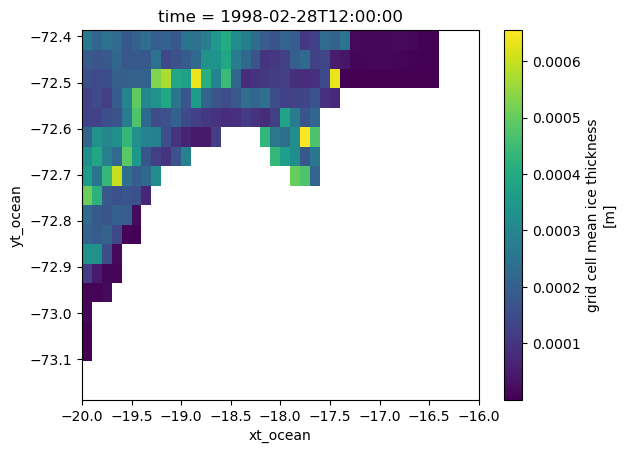

In [101]:
test.sel(time = t, yt_ocean = slice(-73.2, -72.4), xt_ocean = slice(-20, -16)).plot()

In [73]:
x = crabeaters[(np.isnan(crabeaters.depth_m)) & (crabeaters.basis_reco == "HUMAN_OBSERVATION")]

## Extracting data for each observation and adding it to a new column in crabeater data

depth_m


<AxesSubplot:>

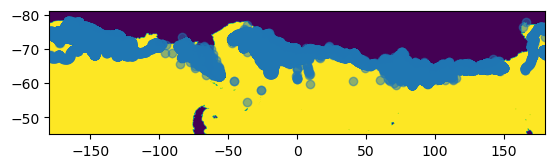

In [19]:
# from rasterio.plot import show
# ras = rasterio.open(file_path)
print(var)
fig, ax = plt.subplots()
ax = rasterio.plot.show(ras, ax = ax)
crabeaters.plot(ax = ax, alpha = 0.5)

In [80]:
# new_crab[var] = [x[0] for x in ras.sample(coord_list)]
# new_crab.head()
# [x[0] for x in ras.sample(coord_list)]
# crabeaters[(np.isnan(crabeaters.bottom_slope_deg)) & (crabeaters.basis_reco == 'HUMAN_OBSERVATION')]
len(x)

135

<GeoAxesSubplot:>

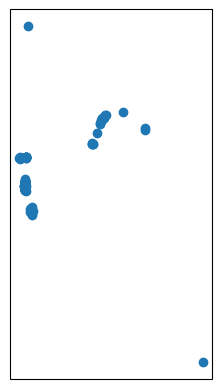

In [74]:
fig = plt.figure()
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
x.plot(ax = ax, transform = ccrs.PlateCarree())

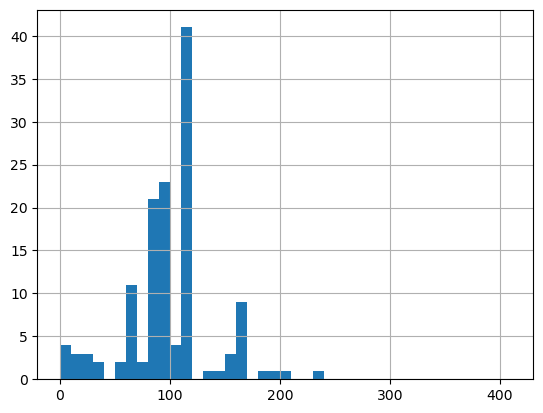

In [77]:
# no_ocean_data = crabeaters[(np.isnan(crabeaters.bottom_slope_deg)) & (crabeaters.basis_reco == 'HUMAN_OBSERVATION')]
x.dist_coast_km.hist(bins = np.arange(0, 420, 10))
no_ocean_data = x

<GeoAxesSubplot:>

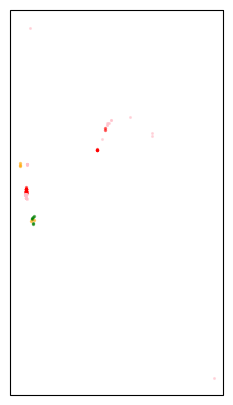

In [78]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
less_20 = no_ocean_data[no_ocean_data.dist_coast_km <= 20]
more_20_less_40 = no_ocean_data[(no_ocean_data.dist_coast_km > 20) & (no_ocean_data.dist_coast_km <= 40)]
more_40_less_100 = no_ocean_data[(no_ocean_data.dist_coast_km > 40) & (no_ocean_data.dist_coast_km <= 100)]
more_100 = no_ocean_data[no_ocean_data.dist_coast_km > 100]
less_20.plot(ax = ax, transform = ccrs.PlateCarree(), color = 'green', alpha = 0.5, markersize = 2)
more_20_less_40.plot(ax = ax, transform = ccrs.PlateCarree(), color = 'orange', alpha = 0.5, markersize = 2)
more_40_less_100.plot(ax = ax, transform = ccrs.PlateCarree(), color = 'red', alpha = 0.5, markersize = 2)
more_100.plot(ax = ax, transform = ccrs.PlateCarree(), color = 'pink', alpha = 0.5, markersize = 1.5)

In [63]:
len(more_100)

3415